1. Choose dataset which will work for any case
2. Define ConvNet as python class
3. Perform Comparative analysis of error/loss.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

#### Dataset Preaparation: Lets use **FashionMNIST** here

In [3]:
(ds_train,ds_test),ds_info = tfds.load("cifar10", split=['train', 'test'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete3RNBY2/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete3RNBY2/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


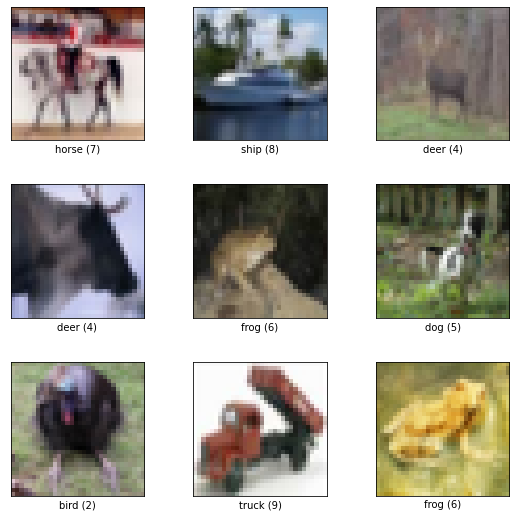

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [ ]:
# Draw single tensor from the dataset and check contents

# sample_ds =  ds_train.take(1)
# for img,label in sample_ds:
#   print(img, label)

In [5]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [6]:
input_shape = ds_info.features["image"].shape
num_classes = ds_info.features["label"].num_classes

We can add preprocessing layer while compiling our model, Here I checked output results using Normalization and Rescaling layers

In [7]:
import numpy as np

mat_val = np.random.randint(0, 255,(1,3))
print("Mat Val = ",mat_val)

layer_norm = tf.keras.layers.Normalization(mean=128,variance=1)
layer_rescale = tf.keras.layers.Rescaling(1.0/255)

print("Normalization-->",layer_norm(mat_val))
print("Rescale-->", layer_rescale(mat_val))

Mat Val =  [[ 52 212 129]]
Normalization--> tf.Tensor([[-76.  84.   1.]], shape=(1, 3), dtype=float32)
Rescale--> tf.Tensor([[0.20392159 0.8313726  0.5058824 ]], shape=(1, 3), dtype=float32)


In [1]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

In [27]:
class LeNet:
  def __init__(self,input_shape, num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def load_model(self,):
    inputs = tf.keras.Input(shape=self.input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    conv1 = tf.keras.layers.Conv2D(filters=6,kernel_size=5,padding='valid',activation='tanh',name='conv1')(x)
    pool1 = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2,name='pool1')(conv1)
    conv2 = tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='tanh',name='conv2')(pool1)
    pool2 = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2,name='pool2')(conv2)
    conv3 = tf.keras.layers.Conv2D(filters=120,kernel_size=5,activation='tanh',name='conv3')(pool2)
    flat = tf.keras.layers.Flatten(name='flatten')(conv3)
    hidden1 = tf.keras.layers.Dense(84, activation='tanh',name='hidden1')(flat)
    outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax',name='Output')(hidden1)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs,name="LeNet-5")


lenet = LeNet(input_shape=input_shape, num_classes=num_classes)
ma_model = lenet.load_model()
ma_model.summary()

ma_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


lenet_history = ma_model.fit(ds_train,
                       epochs=10,
                       validation_data=ds_test)

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 6)         456       
                                                                 
 pool1 (AveragePooling2D)    (None, 14, 14, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 pool2 (AveragePooling2D)    (None, 5, 5, 16)          0         
                                                                 
 conv3 (Conv2D)              (None, 1, 1, 120)         4812

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 47s 119ms/step - loss: 1.8401 - accuracy: 0.3462 - val_loss: 1.7219 - val_accuracy: 0.3921
Epoch 2/10
391/391 [==============================] - 45s 115ms/step - loss: 1.6629 - accuracy: 0.4152 - val_loss: 1.5952 - val_accuracy: 0.4401
Epoch 3/10
391/391 [==============================] - 49s 125ms/step - loss: 1.5383 - accuracy: 0.4553 - val_loss: 1.5064 - val_accuracy: 0.4653
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 1.4402 - accuracy: 0.4894 - val_loss: 1.4187 - val_accuracy: 0.4910
Epoch 5/10
391/391 [==============================] - 51s 129ms/step - loss: 1.3680 - accuracy: 0.5149 - val_loss: 1.3862 - val_accuracy: 0.5026
Epoch 6/10
391/391 [==============================] - 53s 134ms/step - loss: 1.3094 - accuracy: 0.5355 - val_loss: 1.3374 - val_accuracy: 0.5250
Epoch 7/10
391/391 [==============================] - 45s 116ms/step - loss: 1.2658 - accuracy: 0.5502 - val_loss: 1.3308 - val_accuracy: 0.5

#### Learning Curves for LeNet-5

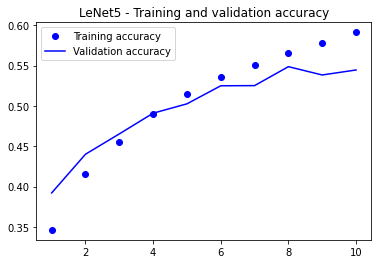

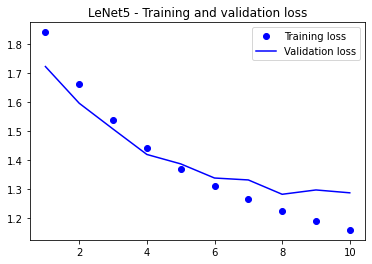

In [30]:
plot_loss_accuracy(lenet_history)

In [ ]:
# NOTE: AlexNet paper also applied Data Augmentation techniques, perhaps try adding those layers too..
class AlexNet:
  def __init__(self,input_shape, num_classes):    
    self.input_shape = input_shape
    self.num_classes = num_classes

  def load_model(self):
    inputs = tf.keras.layers.Input(shape=self.input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), padding='same', strides=(4,4), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(4096,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='AlexNet')


alxnet = AlexNet(input_shape=input_shape, num_classes=num_classes)
alx_model = alxnet.load_model()
alx_model.summary()

alx_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


alx_history = alx_model.fit(ds_train,
                       epochs=10,
                       validation_data=ds_test)    

plot_loss_accuracy(alx_history)

Model: "InceptionNet-1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 256, 256, 96  384         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 16  64          ['input_6[0][0]']                
                                )                                                    

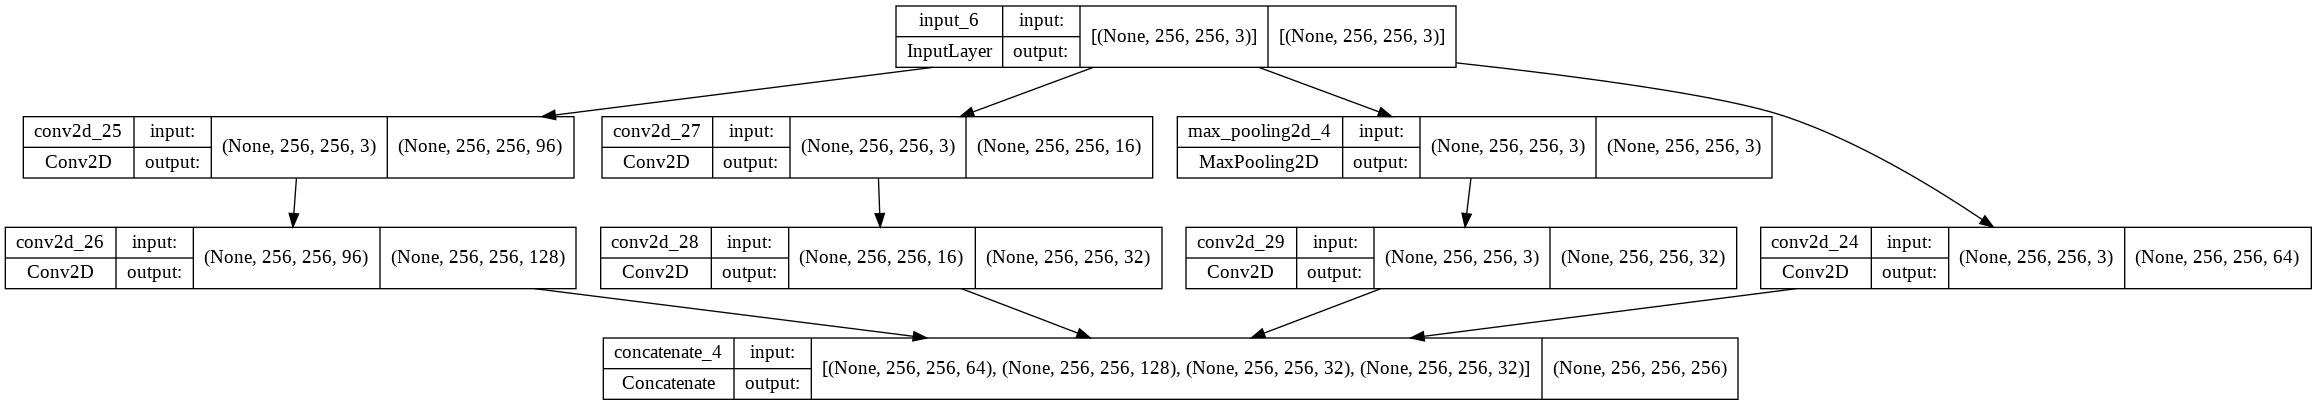

In [14]:
class GoogLeNet:
  def __init__(self,input_shape, num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def __inception_block(self,x,f1,f2,f2_out,f3,f3_out,f4_out):
    p1_out = tf.keras.layers.Conv2D(f1,kernel_size=(1,1), strides=1, padding="same")(x)

    p2 = tf.keras.layers.Conv2D(f2,kernel_size=(1,1), strides=1, padding="same")(x)
    p2_out = tf.keras.layers.Conv2D(f2_out,kernel_size=(3,3), strides=1, padding="same")(p2)

    p3 = tf.keras.layers.Conv2D(f3,kernel_size=(1,1), strides=1, padding="same")(x)
    p3_out = tf.keras.layers.Conv2D(f3_out,kernel_size=(5,5), strides=1, padding="same")(p3)

    p4 = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding="same")(x)
    p4_out = tf.keras.layers.Conv2D(f4_out,kernel_size=(1,1), strides=1, padding="same")(p4)

    inception_block = tf.keras.layers.concatenate([p1_out, p2_out, p3_out, p4_out], axis=-1)
    return inception_block


  def load_model(self):
    input = tf.keras.layers.Input(shape=self.input_shape)
    output = self.__inception_block(input,64,96,128,16,32,32)

    return tf.keras.Model(inputs=[input], outputs=[output], name="InceptionNet-1")

inception1 = GoogLeNet((256,256,3),10)

model = inception1.load_model()

model.summary()

dot_img_file = "inception1.png"
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
